In [3]:
import osmnx as ox 
import networkx as nx 
import geopandas as gpd 
import pandas as pd 
import matplotlib.pyplot as plt 

In [4]:
import os 
import sys 

sys.path.append(os.path.abspath(os.path.join('../')))
from user.params.io import INSTALL_DIR, PROJECT_NAME

In [5]:
from src.utils.logger import setup_logger

In [6]:
from tqdm import tqdm

In [7]:
log = setup_logger('street-parking')
log.setLevel('INFO')

In [8]:
STREET_PARKING_DATA_PATH = "../data/coords/parking_regulations.csv"
GEOCODED_DATA_PATH = '{INSTALL_DIR}/{PROJECT_NAME}/geocoding/geocoded_dataset.csv"

In [9]:
nyc = gpd.read_file("../data/geo/nyc_nta/nynta2020.shp", crs="EPSG:4326")
nyc = nyc.to_crs("EPSG:2263")

In [10]:
nyc_graph = ox.io.load_graphml("../data/geo/nyc.graphml")

In [11]:
nyc_nodes, nyc_roads = ox.graph_to_gdfs(nyc_graph, nodes=True, edges=True)

In [12]:
gcsp = pd.read_csv(GEOCODED_DATA_PATH, engine='pyarrow')

In [13]:
# drop rows with score < 0.99
gcsp = gcsp[gcsp['score_1'] >= 0.99]
gscp = gcsp[gcsp['score_2'] >= 0.99]

In [14]:
# subdataframe with all columns that have _1 suffix
gcsp_1 = gcsp.filter(regex='_1$', axis=1)

In [15]:
# subdataframe with all columns that have _2 suffix
gcsp_2 = gcsp.filter(regex='_2$', axis=1)

In [16]:
gcsp_1 = gpd.GeoDataFrame(gcsp_1, geometry=gpd.points_from_xy(gcsp_1.lng_1, gcsp_1.lat_1), crs="EPSG:4326")
gcsp_1 = gcsp_1.to_crs("EPSG:2263")

In [17]:
gcsp_2 = gpd.GeoDataFrame(gcsp_2, geometry=gpd.points_from_xy(gcsp_2.lng_2, gcsp_2.lat_2), crs="EPSG:4326")
gcsp_2 = gcsp_2.to_crs("EPSG:2263")

In [18]:
len_before_1 = len(gcsp_1)
len_before_2 = len(gcsp_2)

In [19]:
#remove points in gcsp_1 that are not in nyc
gcsp_1 = gpd.sjoin(gcsp_1, nyc, how="inner", predicate='intersects')
log.info(f"Removed {len_before_1 - len(gcsp_1)} points from gcsp_1 that are not in nyc, total percentage removed: {(len_before_1 - len(gcsp_1))/len_before_1}")

2023-11-12 21:15:01 - street-parking - INFO - Removed 402 points from gcsp_1 that are not in nyc, total percentage removed: 0.004186191815057794


In [20]:
# remove points in gcsp_2 that are not in nyc
gcsp_2 = gpd.sjoin(gcsp_2, nyc, how="inner", predicate='intersects')
log.info(f"Removed {len_before_2 - len(gcsp_2)} points from gcsp_2 that are not in nyc, total percentage removed: {(len_before_2 - len(gcsp_2))/len_before_2}")

2023-11-12 21:15:02 - street-parking - INFO - Removed 408 points from gcsp_2 that are not in nyc, total percentage removed: 0.004248672289909403


In [21]:
# snap every point in gcsp_1 to the nearest node in nyc_nodes
gcsp_1['nearest_node'] = ox.nearest_nodes(nyc_graph, gcsp_1.geometry.x, gcsp_1.geometry.y)

In [22]:
# snap every point in gcsp_2 to the nearest node in nyc_nodes
gcsp_2['nearest_node'] = ox.nearest_nodes(nyc_graph, gcsp_2.geometry.x, gcsp_2.geometry.y)

In [23]:
# make u,v edges from nearest nodes in gcsp_1 and gcsp_2
gcsp['u'] = gcsp_1['nearest_node'].astype(int)
gcsp['v'] = gcsp_2['nearest_node'].astype(int)

In [24]:
# drop any rows of gcsp with nan in 'u' or 'v' 
gcsp.dropna(subset=['u', 'v'], inplace=True)

In [25]:
# tuple of u,v edges
gcsp['uv'] = list(zip(gcsp['u'].astype(int), gcsp['v'].astype(int)))

In [26]:
counter = 0
for uv in tqdm(gcsp['uv'], desc="Checking if edges in gcsp are in nyc_graph"):
    if uv not in nyc_graph.edges:
        counter += 1

log.info(f"Detected {counter} edges from gcsp that are not in nyc_graph, total percentage detected: {counter/len(gcsp)}")

Checking if edges in gcsp are in nyc_graph: 100%|██████████| 95349/95349 [00:00<00:00, 1182140.00it/s]
2023-11-12 21:15:03 - street-parking - INFO - Detected 29829 edges from gcsp that are not in nyc_graph, total percentage detected: 0.31284019758990655


In [27]:
nyc_street_parking = nx.create_empty_copy(nyc_graph)

In [28]:
nyc_street_parking.add_edges_from(gcsp['uv'])

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,


Getting lengths of edges in nyc_street_parking:   0%|          | 0/95349 [00:00<?, ?it/s]

ValueError: too many values to unpack (expected 2)

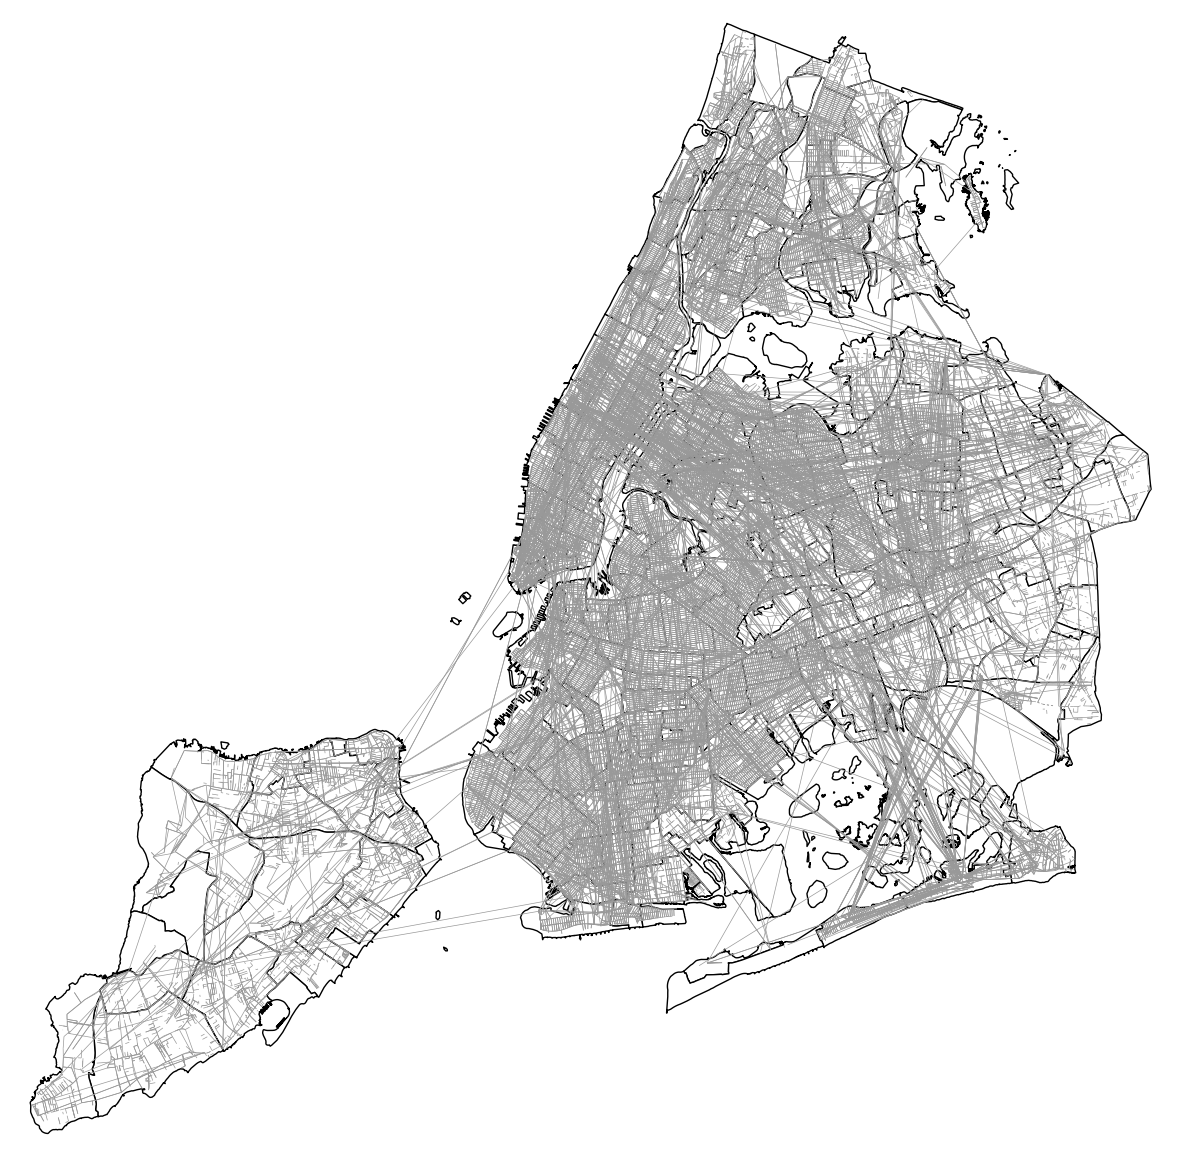

(<Figure size 1500x1500 with 1 Axes>, <Axes: >)

In [ ]:
fig, ax = plt.subplots(figsize=(15,15))
nyc.plot(ax=ax, color='white', edgecolor='black')
ox.plot_graph(nyc_street_parking, ax=ax, node_size=0, edge_linewidth=0.5)

# for i, row in gcsp_1.iterrows():
